# Import data

In [1]:
import pandas as pd
import numpy as np

# Do experiments with one country

In [13]:
df = pd.read_csv("sars_2003_complete_dataset_clean.csv")

China = df[df.Country == "China"]
China = China.drop("Country",axis=1) 
China.columns = ['Date', "cum", "death", "rec"]
China['Date']= pd.to_datetime(China['Date']) 
China['Date'] = China['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

# China['Date'] = China['Date'].apply(lambda x: x.strftime('%m/%d/%Y'))
China = China.set_index('Date')

# cum = China.cum
# rec = China.rec
# death = China.death
# data=cum
China.cum
# China.info()

Date
2003-03-18       0
2003-03-19       0
2003-03-20       0
2003-03-21       0
2003-03-22       0
              ... 
2003-07-07    5327
2003-07-08    5327
2003-07-09    5327
2003-07-10    5327
2003-07-11    5327
Name: cum, Length: 96, dtype: int64

In [12]:
China

Date
2003-03-18       0
2003-03-19       0
2003-03-20       0
2003-03-21       0
2003-03-22       0
              ... 
2003-07-07    5327
2003-07-08    5327
2003-07-09    5327
2003-07-10    5327
2003-07-11    5327
Name: cum, Length: 96, dtype: int64

### Data visualisation

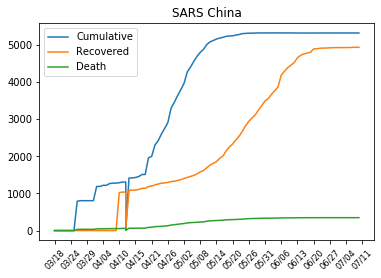

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data(df,label,countryName="SARS China"):
    ind = np.arange(0,len(China),5)
    indNames = [China.index[i] for i in range(len(China)) if i %5 ==0]

    plt.plot(df,label=label)
    plt.xticks(ind,indNames, rotation=45,fontsize='small');
    plt.legend()
    plt.title(countryName)
#     plt.show()


plot_data(cum,"Cumulative")
plot_data(rec, "Recovered")
plot_data(death, "Death")

# Models

## 1. SARIMAX

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
#Get increasing index
def reset_index(df):
    index = np.arange(1,len(df)+1)
    df = df.set_index(index)
    return df

China = reset_index(China)
cum = China.cum
rec = China.rec
death = China.death

In [5]:
cum

1        0
2        0
3        0
4        0
5        0
      ... 
92    5327
93    5327
94    5327
95    5327
96    5327
Name: cum, Length: 96, dtype: int64

0 rounds done
0 rounds done
0 rounds done


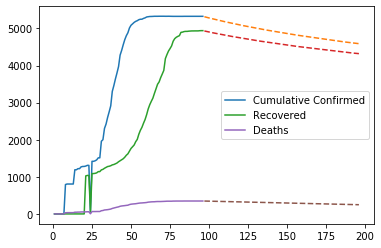

In [6]:
datasets = [cum,rec,death] 
titles = ["Cumulative Confirmed", "Recovered", "Deaths"]

import warnings
warnings.filterwarnings('ignore')

def model_stuff(data,n,titles):
    for k in range(len(datasets)): 
        data = datasets[k]
        for i in range(n):
            if i % 250 == 0:
                print("{} rounds done".format(i))
            mod = sm.tsa.SARIMAX(data, order=(1, 0, 0), trend='c')
            res = mod.fit()
            new = pd.DataFrame([pd.Series([int(res.forecast())])])
            data = pd.concat([data,new])
            data = reset_index(data)
        plt.plot(data[:96],label=titles[k])
        plt.plot(data[96:],ls='--')
        plt.legend()

n= 100
model_stuff(data,n,titles)

### WIP Cross Validation with dataset

In [56]:
# Monthly frequency, using a DatetimeIndex
data = cum
index = pd.date_range(start='2003', periods=len(data), freq='D')
data = pd.Series(data.values,index=index)

# Step 1: fit model parameters training sample
training_obs = int(len(data) * 0.8)

training_data = data[:training_obs]
training_mod = sm.tsa.SARIMAX(
    training_data, order=(1, 0, 0), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
fcast = training_res.forecast()

# Step 3: compute root mean square forecasting error
true = data.reindex(fcast.index)
error = true - fcast

# Print out the results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))

intercept       14.682233
ar.L1            0.994638
sigma2       66919.386724
dtype: float64
            true     forecast      error
2003-03-18  5326  5313.121355  12.878645


##### Second iteration 

In [89]:
append_res

In [57]:
# Step 1: append a new observation to the sample and refit the parameters
append_res = training_res.append(data[training_obs:training_obs + 1], refit=True)
# Step 2: produce one-step-ahead forecasts
fcast = append_res.forecast()

# Step 3: compute root mean square forecasting error
true = data.reindex(fcast.index)
error = true - fcast

# Print out the results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))

            true     forecast      error
2003-03-19  5326  5312.305271  13.694729


##### Recursive forecast evaluation

In [101]:
# Monthly frequency, using a DatetimeIndex
data = cum
index = pd.date_range(start='2003', periods=len(data), freq='D')
data = pd.Series(data.values,index=index)

# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(data)
n_init_training = int(nobs * 0.8)
init_training_data = data[:n_init_training]
# print("init_training_data\n",init_training_data)
#Initialize model
mod = sm.tsa.SARIMAX(init_training_data, order=(1, 0, 0), trend='c')
res = mod.fit()

# # Save initial forecast
# forecasts[training_data.index[-1]] = res.forecast(steps=nforecasts)
# print("======================")
# Step through the rest of the sample
for t in range(n_init_training, nobs):
    updated_data = data.iloc[t:t+1][0]
    print(updated_data)
#     print(updated_data)
#     updated_data = updated_data[0]
#     print("updated_data:",updated_data)
#     print("\n")
    res = res.append(updated_data, refit=False)
    
#     append_res = training_res.append(data[t:t + 1], refit=True)
# fcast = append_res.forecast()
# true = data.reindex(fcast.index)
# error = true - fcast

#     # Save the new set of forecasts
#     forecasts[updated_data.index[0]] = res.forecast(steps=nforecasts)

# # Combine all forecasts into a dataframe
# forecasts = pd.concat(forecasts, axis=1)

# print(forecasts.iloc[:5, :5])

5326


TypeError: object of type 'numpy.int64' has no len()

# Kalman Filter

# Visualize on plots

In [ ]:
gmplot